# Dataset analysis

Plots and stats for the meta dataset, after removing outliers, before sequence clustering.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
)
from subpred.util import get_feature_score
from subpred.pssm import calculate_pssms_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## Creating the dataset

In [11]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[3702, 9606, 83333, 559292],
    output_log="../logs/meta_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"]  # human
    + ["P76773", "Q47706", "P02943", "P75733", "P69856", "P64550"]  # Ecoli
    + [
        "O81775",
        "Q9SW07",
        "Q9FHH5",
        "Q8S8A0",
        "Q3E965",
        "Q3EAV6",
        "Q3E8L0",
    ],  # athliana
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    83333: "E. coli",
    559292: "Yeast",
}
df = df.assign(organism=df.organism_id.map(taxid_to_organism))


In [12]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence,organism
Uniprot,,,,,,,,,,
P0CD99,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,MPH2 YDL247W,Alpha-glucosides permease MPH2 (Maltose transp...,NaN,0.0,559292,MKNLSFLINRRKENTSDSNVYPGKAKSHEPSWIEMDDQTKKDGLDI...,Yeast
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,4.A,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...,E. coli
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...,A. thaliana
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...,Human
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...,A. thaliana


### Stats

Imbalanced dataset, the number of sugar transporters might be a bit low.

In [13]:
df.keywords_transport.value_counts()

Sugar transport         228
Amino-acid transport    185
Name: keywords_transport, dtype: int64

In [14]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                               182
Cell inner membrane;Cell membrane;Membrane;Transmembrane              98
Cell membrane;Membrane;Transmembrane                                  97
Endoplasmic reticulum;Membrane;Transmembrane                          19
Membrane;Mitochondrion;Transmembrane                                   9
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane             3
Membrane;Mitochondrion;Mitochondrion inner membrane;Transmembrane      3
Membrane;Plastid inner membrane;Transmembrane                          1
Cell membrane;Membrane;Nucleus;Transmembrane                           1
Name: keywords_location, dtype: int64

In [15]:
df.keywords_transport_related.value_counts()

Transport                     306
Symport;Transport              78
Antiport;Transport             27
Antiport;Symport;Transport      2
Name: keywords_transport_related, dtype: int64

#### TCDB


In [16]:
df.tcdb_class.value_counts()

2.A    250
0.0    123
3.A     23
4.A     17
Name: tcdb_class, dtype: int64

## Feature generation

In [18]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)
df_pssm = calculate_pssms_notebook(sequences=df.sequence)

Two principal components are likely not enough to capture the differences between sugar transporters and amino acid transporters, but they are able to distinguish the prokaryote (E coli) from the Eukaryotes. We will perform an additional evaluation without E coli, and see if that improves the results. The dataset seem to follow the pattern we found for the individual organisms, which is that sugar transporters have higher variance across the PC1 and PC2 axes than the amino acid transporters. Often, there is a cluster of AA transporters, surrounded by sugar transporters. This explains why RBFSVC works well here.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

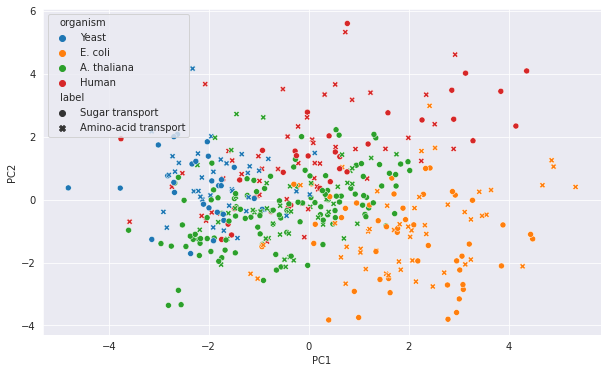

In [34]:
pca_plot_2d(df_aac, df.organism, labels)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

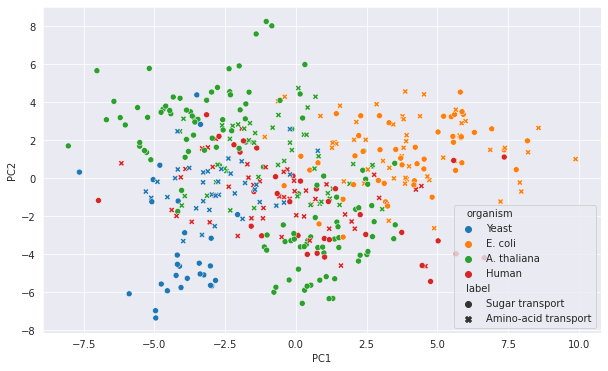

In [26]:
pca_plot_2d(df_paac, df.organism, labels)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

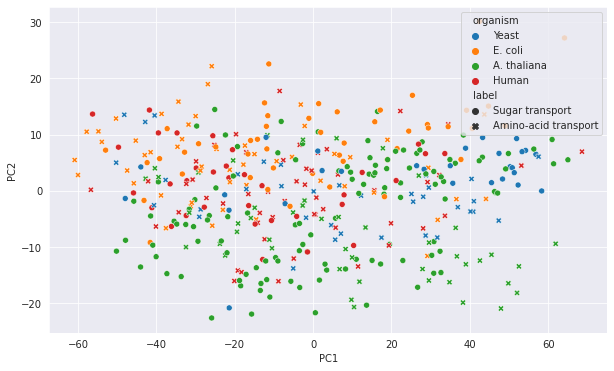

In [29]:
pca_plot_2d(df_pssm, df.organism, labels)

Hierarchical clustering can't quite distinguish all transporters into their categories:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fcb0a149670>)

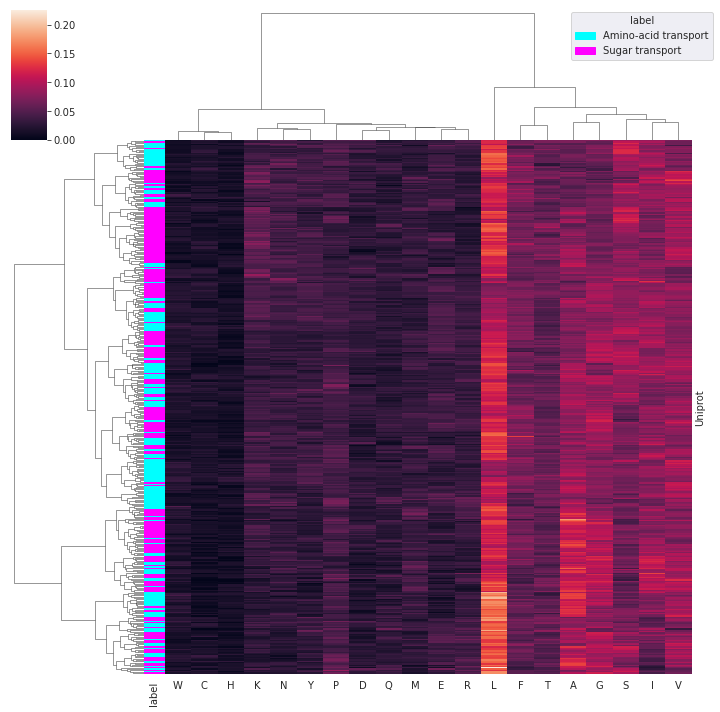

In [35]:
labeled_clustermap(df_aac, labels, xlabels="auto")

### PAAC plot

The number of dipeptides with relatively high frequency is relatively low:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fcb245e5940>)

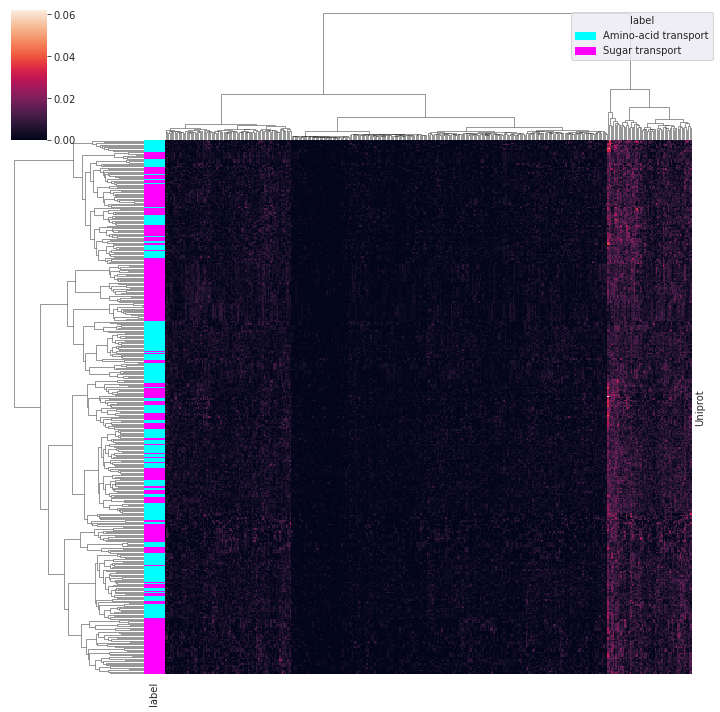

In [36]:
labeled_clustermap(df_paac, labels)

In [21]:
get_feature_score(df_paac, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).reset_index(drop=True).head(20)

,Feature,Normalized score,Measure
0,YW,0.028656,Feature importance (f_classif)
1,GR,0.027731,Feature importance (f_classif)
2,LP,0.022366,Feature importance (f_classif)
3,QQ,0.020123,Feature importance (f_classif)
4,CY,0.017585,Feature importance (f_classif)
5,ET,0.016554,Feature importance (f_classif)
6,AY,0.013926,Feature importance (f_classif)
7,KT,0.013695,Feature importance (f_classif)
8,GI,0.013507,Feature importance (f_classif)
9,FP,0.012110,Feature importance (f_classif)


The frequencies of the dipeptides Thyrosine-Thryptophane and Glycine-Arginine seem to be most important, possibly they lead to structural changes or substrate specificity.

In [37]:
get_feature_score(df_pssm, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).reset_index(drop=True).head(20)

,Feature,Normalized score,Measure
0,MP_50_3,0.007759,Feature importance (f_classif)
1,MP_50_1,0.006467,Feature importance (f_classif)
2,MP_90_1,0.006268,Feature importance (f_classif)
3,MP_90_3,0.006225,Feature importance (f_classif)
4,IQ_50_1,0.004902,Feature importance (f_classif)
5,HH_50_3,0.004442,Feature importance (f_classif)
6,EH_90_1,0.004381,Feature importance (f_classif)
7,HH_90_1,0.004250,Feature importance (f_classif)
8,DH_50_3,0.003977,Feature importance (f_classif)
9,EH_90_3,0.003964,Feature importance (f_classif)


When it comes to the PSSM, the exchange rate of Methionine for Proline seems to be very important, which could lead to structural changes, as well as  the conservation of Histidine, which is known to be reactive.

#### Antiport, Symport, Uniport

No distict clusters show up in the data, when annotating the clusters with transport mechanism.

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7fcb19b5e8b0>)

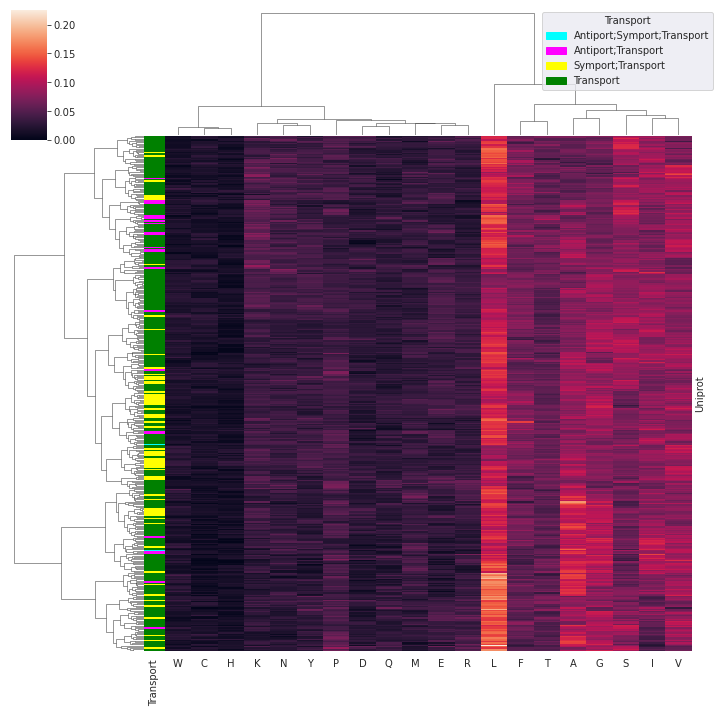

In [38]:
labeled_clustermap(
    df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto"
)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

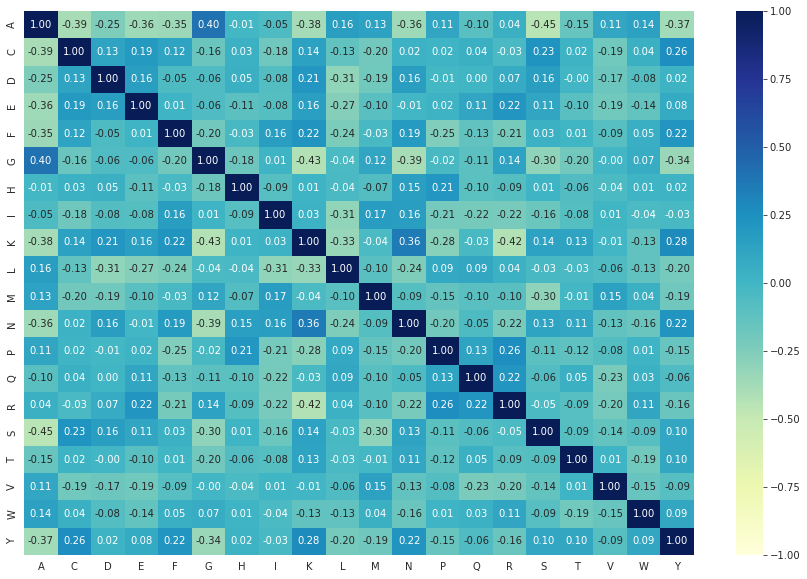

In [39]:
corr_heatmap(df_aac)

<AxesSubplot:>

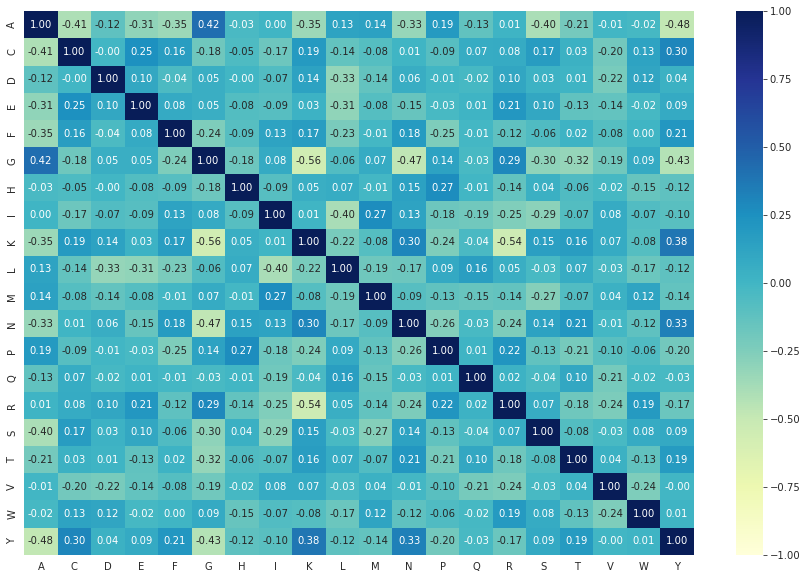

In [40]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

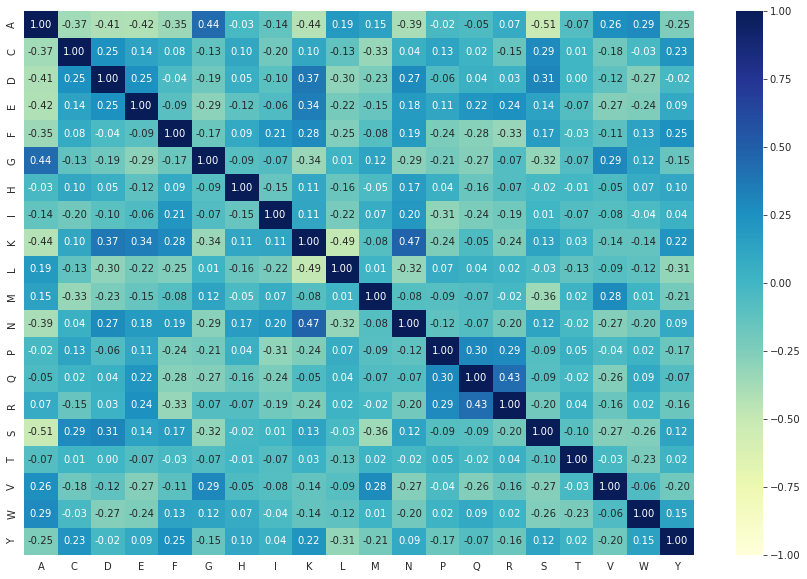

In [41]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

In [42]:
df_aac_long = (
    df_aac.stack(level=None)
    .reset_index()
    .rename(columns={"level_1": "Amino Acid", 0: "Frequency"})
    .merge(df.keywords_transport, left_on="Uniprot", right_index=True)
)
df_aac_long.head()

,Uniprot,Amino Acid,Frequency,keywords_transport
0,P0CD99,A,0.072250,Sugar transport
1,P0CD99,C,0.029557,Sugar transport
2,P0CD99,D,0.036125,Sugar transport
3,P0CD99,E,0.049261,Sugar transport
4,P0CD99,F,0.062397,Sugar transport


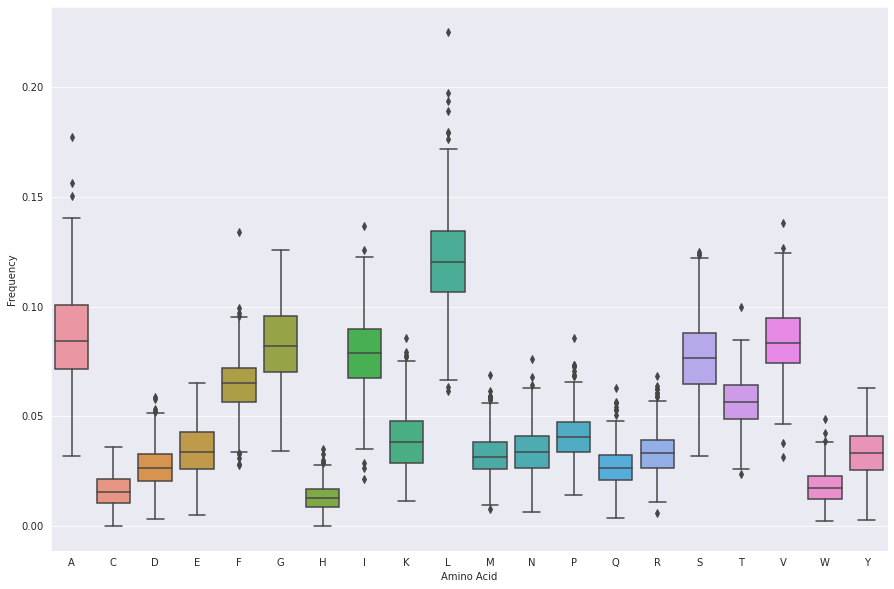

In [43]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    # hue="keywords_transport"
)

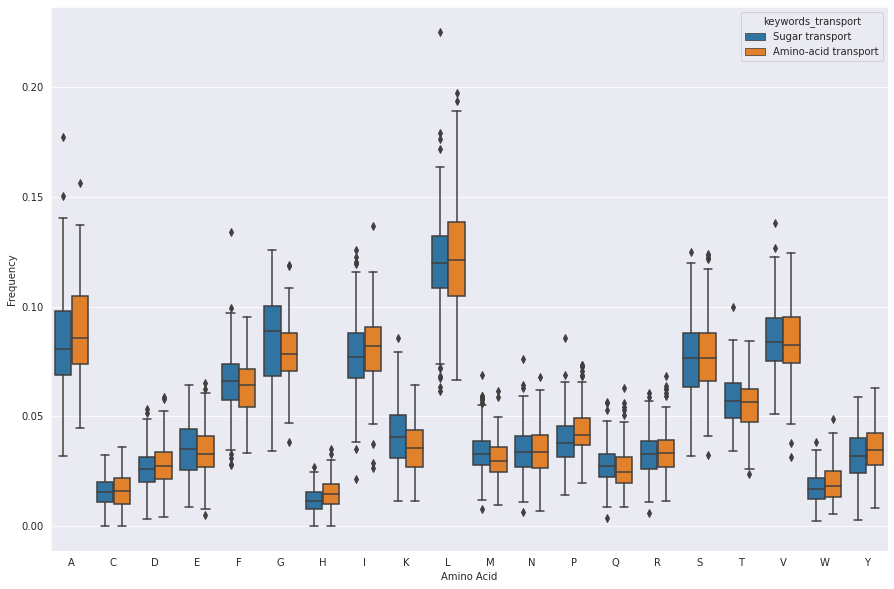

In [44]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    hue="keywords_transport"
)

There does not seem to be a clear distinguishing factor. The classification probably has to be carried out using a combination of several features.

According to shapiro-wilk, the features now follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

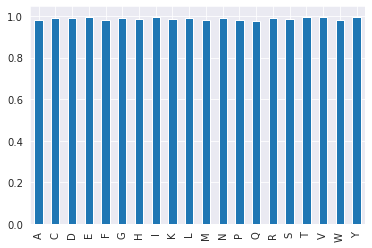

In [45]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

## Additional plots

### TCDB class

The non-TCDB proteins mix well with the 2.A proteins, suggesting that they share a similar sequence composition. The 3.A and 4.A proteins are located in the E Coli cluster, since they only occur in that organism. 

({'0.0': 'cyan', '2.A': 'magenta', '3.A': 'yellow', '4.A': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7fcb24255310>)

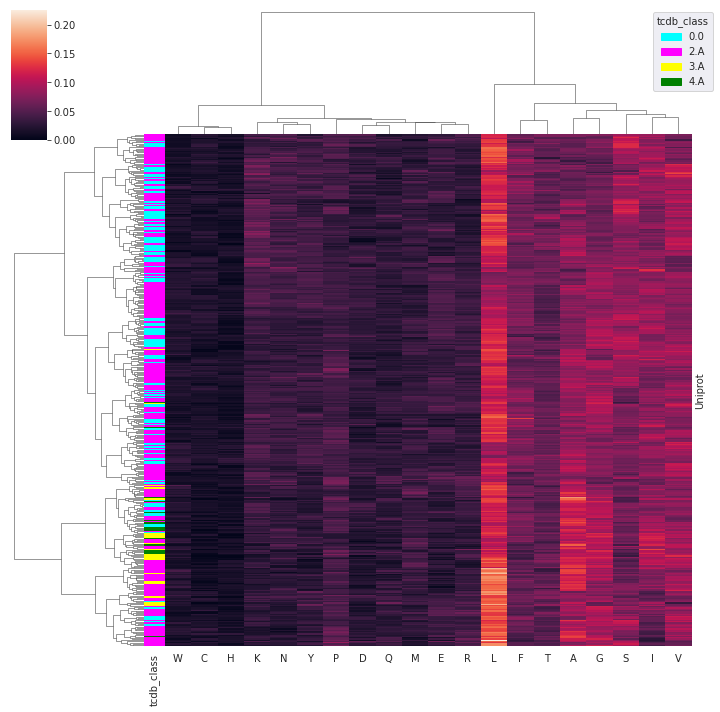

In [46]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")

## PCA plots

PCA plots for AAC and PAAC, the first two and three PC's.

### AAC

The data is not that clearly separable with just the AAC and the first two or thee PCs

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

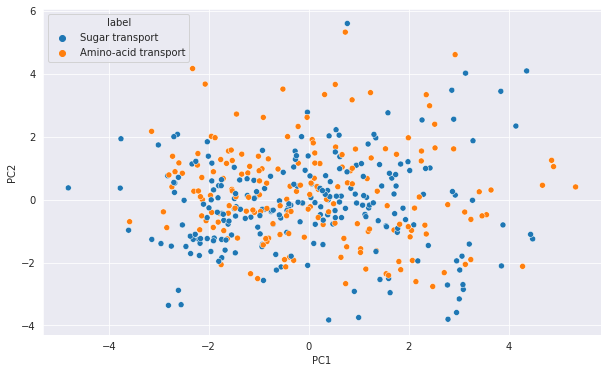

In [47]:
pca_plot_2d(df_aac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

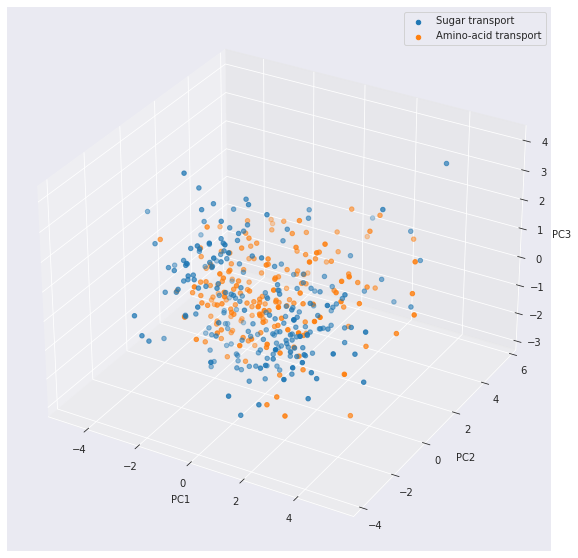

In [55]:
pca_plot_3d(df_aac, labels)

### PAAC



<AxesSubplot:xlabel='PC1', ylabel='PC2'>

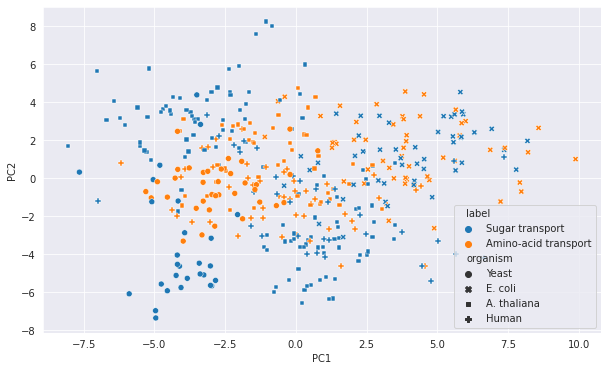

In [53]:
pca_plot_2d(df_paac, labels, df.organism)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

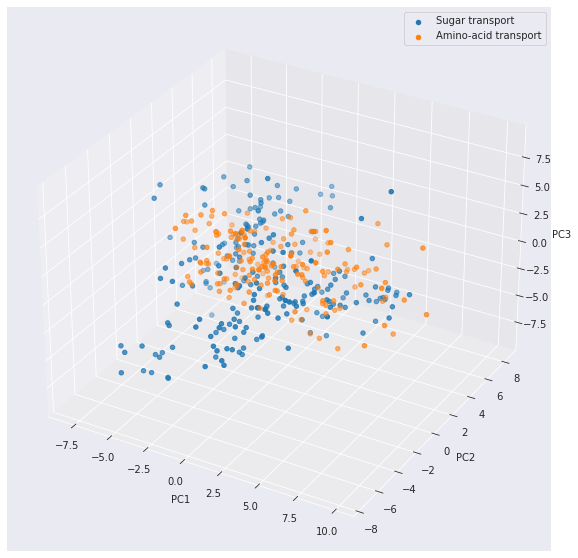

In [50]:
pca_plot_3d(df_paac, labels)

With PAAC, there is a hint of a pattern where amino acid transporters have higher variance in the PCs. RBF kernel could work, if we add more dimensions (i.e. more than two)

### PSSM plots


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

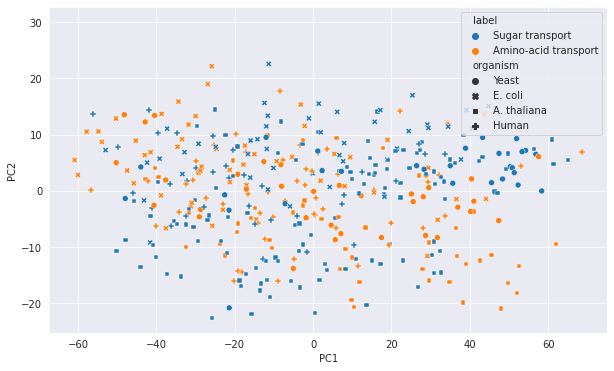

In [56]:
pca_plot_2d(df_pssm, labels, df.organism)

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fcb19174490>)

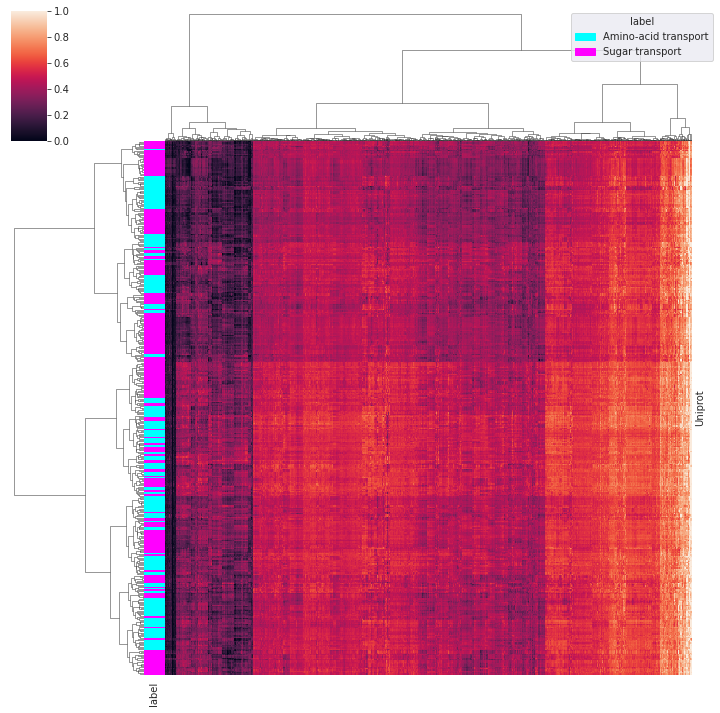

In [57]:
labeled_clustermap(df_pssm, labels)

## F score Plot

The feature importance values show Glutamic acid as the most important feature. This amino acid, or rather its conservation, is also very prominent among the most important PSSM features (see above). Another important amino acid, the most important according to the chi2 score, is Lysine, another postive and reactive AA that can lead to substrate specificity.

Generally, we see the pattern again of less-frequently occuring amino acids having more impact on the model.

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

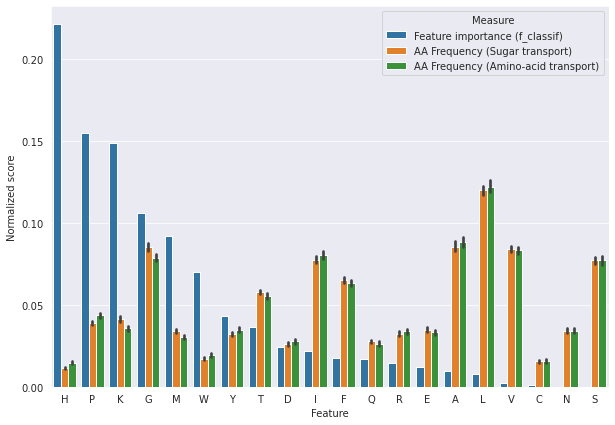

In [58]:
feature_importance_plot(df_aac, labels, method="f_classif")

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

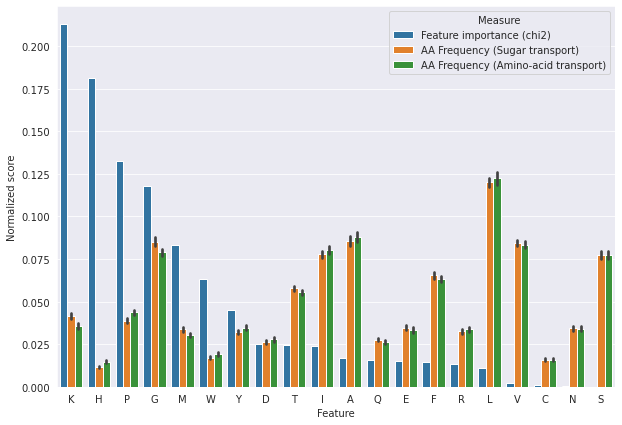

In [59]:
feature_importance_plot(df_aac, labels, method="chi2")